### SVHN Process Dataset

SVHN dataset is a dataset of about 200k street numbers, along with bounding boxes for individual digits, giving about 600k digits total.

This notebook processes the dataset and creates 3 separates file sets - train, validate and test.  The image files are created by finding the small rectangular bounding box that will contain individual character bounding boxes.

In [1]:
%load_ext watermark

%watermark -a 'P.S. Aravind' -u -n -t -z -v -m -p numpy,scipy,matplotlib

P.S. Aravind 
last updated: Mon Oct 10 2016 22:53:35 UTC

CPython 2.7.6
IPython 4.1.1

numpy 1.11.2
scipy 0.13.3
matplotlib 1.5.1

compiler   : GCC 4.8.2
system     : Linux
release    : 4.4.20-moby
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


### Import all the needed python libraries

In [2]:
import os
import struct
import numpy as np
import random
import scipy.io as sio
import tarfile
import gzip
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image as Image
import h5py

%matplotlib inline

### Extract train, test and extra zip files from http://ufldl.stanford.edu/housenumbers/

In [3]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s' % (root, filename))
    else:
        print('Extracting data for %s.  This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
    data_folders = root
    return data_folders

In [4]:
train_folders = maybe_extract('train.tar.gz')
test_folders = maybe_extract('test.tar.gz')
extra_folders = maybe_extract('extra.tar.gz')

train already present - Skipping extraction of train.tar.gz
test already present - Skipping extraction of test.tar.gz
extra already present - Skipping extraction of extra.tar.gz


In [5]:
### Parse the DigitStructFile and extract the image, label and bounding boxes for each digit

In [6]:
# https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/5
# The DigitStructFile is just a wrapper around the h5py data.  It basically
# references
# inf:            The input h5 matlab file
# digitStructName The h5 ref to all the file names
# digitStructBbox The h5 ref to all struct data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']
        
# getName returns the 'name' string for the nth digtstruct
    def getName(self, n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])
    
# bboxHelper handles the coding differenc when there is exactly one box or an array of bbox
    def bboxHelper(self, attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the nth bbox
    def getBbox(self, n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]['height'])
        bbox['label'] = self.bboxHelper(self.inf[bb]['label'])
        bbox['left'] = self.bboxHelper(self.inf[bb]['left'])
        bbox['top'] = self.bboxHelper(self.inf[bb]['top'])
        bbox['width'] = self.bboxHelper(self.inf[bb]['width'])
        return bbox
    
    def getDigitStructure(self, n):
        s = self.getBbox(n)
        s['name'] = self.getName(n)
        return s

# getAllDigitStructure return all the digitStruct from the input file
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]
    
# Return a restructured version of the dataset (one structure by boxed digit)
#
# Return a List of such dicts:
#    'filename' : filename of the samples
#    'boxes' : List of such dict (one by digit):
#           'Label' : 1 to 9 corresponding digits. 10 for digit 0 in image
#           'Left', 'top' : position of bounding box
#           'width', 'height' : dimension of bounding box
#
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = {'filename' : pictDat[i]['name']}
            figures = []
            for j in range(len(pictDat[i]['height'])):
                figure = {}
                figure['height'] = pictDat[i]['height'][j]
                figure['label'] = pictDat[i]['label'][j]
                figure['left'] = pictDat[i]['left'][j]
                figure['top'] = pictDat[i]['top'][j]
                figure['width'] = pictDat[i]['width'][j]
                figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result
                

### Crop the image to standard width for processing

Due to memory restrictions in having a large image size, images were grey scalled by converting 3 channels to single channel.

In [7]:
image_size = 32

def crop_images(folder, dataset):
    data = np.ndarray([len(dataset), image_size, image_size], dtype='float32')
    labels = np.ones([len(dataset), 7], dtype=int) * 10
    for i in range(len(dataset)):
        actual_image = Image.open(os.path.join(folder, dataset[i]['filename'])).convert('L')
        box = dataset[i]['boxes']
        labels[i, 0] = len(box)
        top = np.ndarray([labels[i, 0]], dtype='float32')
        left = np.ndarray([labels[i, 0]], dtype='float32')
        height = np.ndarray([labels[i, 0]], dtype='float32')
        width = np.ndarray([labels[i, 0]], dtype='float32')
        for j in range(labels[i, 0]):
            labels[i, 1 + j] = 0 if (box[j]['label'] == 10) else box[j]['label']
            top[j] = box[j]['top']
            left[j] = box[j]['left']
            height[j] = box[j]['height']
            width[j] = box[j]['width']
        
        image_upper = int(np.amin(top))
        image_left = int(np.amin(left))
        image_lower = int(np.amax(top) + height[np.argmax(top)])
        image_right = int(np.amax(left) + width[np.argmax(left)])
        
        actual_image = actual_image.crop((image_left, image_upper, image_right, image_lower)).resize([image_size, image_size], 
                                                                                                    Image.ANTIALIAS)
        
        actual_image = np.array(actual_image, dtype='float32')
        data[i, :, :] = actual_image[:, :]
        
    data = data.reshape((len(dataset), image_size * image_size * 1))
    scaler = preprocessing.StandardScaler()
    data = scaler.fit(data).transform(data).reshape((len(dataset), image_size, image_size, 1))
    return data, labels

### Process train dataset and crop images

In [8]:
structFile = DigitStructFile(os.path.join('train', 'digitStruct.mat'))
trainStructFile = structFile.getAllDigitStructure_ByDigit()

X_train, y_train = crop_images('train', trainStructFile)
del trainStructFile

### Process test dataset and crop images

In [9]:
structFile = DigitStructFile(os.path.join('test', 'digitStruct.mat'))
testStructFile = structFile.getAllDigitStructure_ByDigit()

X_test, y_test = crop_images('test', testStructFile)
del testStructFile

### Process extra dataset and images

In [10]:
structFile = DigitStructFile(os.path.join('extra', 'digitStruct.mat'))
extraStructFile = structFile.getAllDigitStructure_ByDigit()

X_extra, y_extra = crop_images('extra', extraStructFile)
del extraStructFile

### Display train, extra and test shape

In [11]:
print('train ', X_train.shape, y_train.shape)
print('extra ', X_extra.shape, y_extra.shape)
print('test ', X_test.shape, y_test.shape)

('train ', (33402, 32, 32, 1), (33402, 7))
('extra ', (202353, 32, 32, 1), (202353, 7))
('test ', (13068, 32, 32, 1), (13068, 7))


### Concatenate extra dataset to train dataset

In [12]:
X_train = np.concatenate((X_train, X_extra), axis=0)
y_train = np.concatenate((y_train, y_extra), axis=0)

In [13]:
print('train ', X_train.shape, y_train.shape)

('train ', (235755, 32, 32, 1), (235755, 7))


### Split train into train and valid dataset

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print('Train Data shape:', X_train.shape)
print('Train Labels shape:', y_train.shape)
print('Valid Data shape:', X_valid.shape)
print('Valid Labels shape:', y_valid.shape)
print('Test Data shape:', X_test.shape)
print('Test Labels shape:', y_test.shape)

('Train Data shape:', (188604, 32, 32, 1))
('Train Labels shape:', (188604, 7))
('Valid Data shape:', (47151, 32, 32, 1))
('Valid Labels shape:', (47151, 7))
('Test Data shape:', (13068, 32, 32, 1))
('Test Labels shape:', (13068, 7))


### Display SVHN dataset

In [15]:
def display_dataset(dataset, labels):
    fig = plt.figure(figsize=(10,6))
    for i, item in enumerate(random.sample(range(len(labels)), 9)):
        plt.subplot(330 + i + 1)
        plt.imshow(dataset[item].reshape(image_size, image_size))
        label = ''.join(map(str, labels[item][1:labels[item][0]+1]))
        plt.title(label)
        plt.axis('off')
    plt.show()

### Display SVHN train dataset

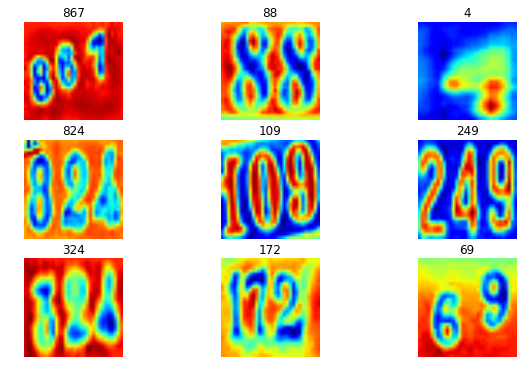

In [16]:
display_dataset(X_train, y_train)

### Display SVHN valid dataset

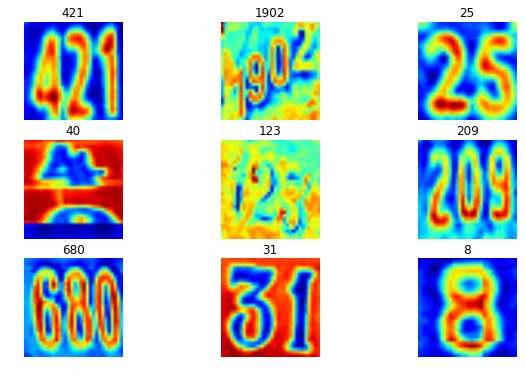

In [17]:
display_dataset(X_valid, y_valid)

### Display SVHN test dataset

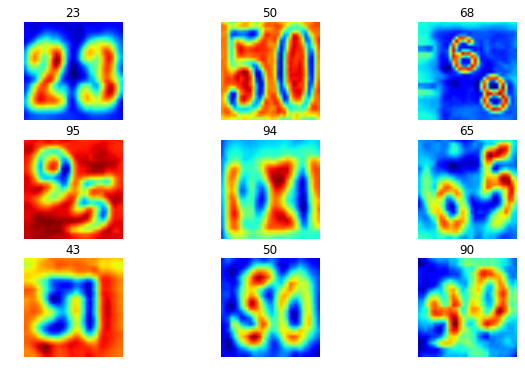

In [18]:
display_dataset(X_test, y_test)

### Split train data set for storing as pickeled file

In [19]:
X_train1, X_train2, X_train3, X_train4 = np.array_split(X_train, 4)
y_train1, y_train2, y_train3, y_train4 = np.array_split(y_train, 4)

In [20]:
print(X_train1.shape, y_train1.shape)
print(X_train2.shape, y_train2.shape)
print(X_train3.shape, y_train3.shape)
print(X_train4.shape, y_train4.shape)

((47151, 32, 32, 1), (47151, 7))
((47151, 32, 32, 1), (47151, 7))
((47151, 32, 32, 1), (47151, 7))
((47151, 32, 32, 1), (47151, 7))


### Zip and store train datasets as pickeled file

In [21]:
pickle_file = './data/SVHN_train1.pklz'

try:
  f = gzip.open(pickle_file, 'wb')
  save = {
    'X_train1': X_train1,
    'y_train1': y_train1
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [22]:
pickle_file = './data/SVHN_train2.pklz'

try:
  f = gzip.open(pickle_file, 'wb')
  save = {
    'X_train2': X_train2,
    'y_train2': y_train2
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [23]:
pickle_file = './data/SVHN_train3.pklz'

try:
  f = gzip.open(pickle_file, 'wb')
  save = {
    'X_train3': X_train3,
    'y_train3': y_train3
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [24]:
pickle_file = './data/SVHN_train4.pklz'

try:
  f = gzip.open(pickle_file, 'wb')
  save = {
    'X_train4': X_train4,
    'y_train4': y_train4
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

### Zip and store valid dataset as pickeled file

In [26]:
pickle_file = './data/SVHN_valid.pklz'

try:
  f = gzip.open(pickle_file, 'wb')
  save = {
    'X_valid': X_valid,
    'y_valid': y_valid
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

### Zip and store test datasets as pickeled file

In [27]:
pickle_file = './data/SVHN_test.pklz'

try:
  f = gzip.open(pickle_file, 'wb')
  save = {
    'X_test': X_test,
    'y_test': y_test
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise